In [1]:
import torchvision.models as models
import torch
from torchvision import transforms
from PIL import Image
from torch.nn.utils.rnn import *
from torch import nn
from torch.utils import data
import time
import pdb
from torch.autograd import Variable

import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
GPU = torch.cuda.is_available()
device = torch.device("cuda" if GPU else "cpu")
cuda = torch.cuda.is_available()
num_workers = 0 if cuda else 0
GPU

False

In [3]:
torch.cuda.empty_cache()

# Reading Data

In [4]:
# Image loading hyperparameters
numDataPointsWanted = 300     # max number is 33808
LOADIMAGES = False              # True if we want to pre-load all images (usually results in MEM errors)

CROPBOX = (0, 200, 640, 480)
IMG_SIZE = (320, 240)

transform = transforms.ToTensor()
root_path = "./"

def load_cropped_resized_image(filename):
    with Image.open(root_path + filename) as img:
         return transform(img.crop(CROPBOX).resize(IMG_SIZE).convert('RGB'))

if LOADIMAGES:
    print("Pre-loading all images..")
    X = np.zeros((numDataPointsWanted, 3, IMG_SIZE[0], IMG_SIZE[1]))
else:
    print("Loading image names only..")
    X = np.zeros((numDataPointsWanted), dtype=object)
Y = np.zeros((numDataPointsWanted, 3))


with open(root_path + "labels.txt") as f:
    start = time.time()
    i = 0
    for line in f:
        [filename, radians, torque, speed] = line.split(' ')

        if LOADIMAGES:
            X[i,:,:,:] = load_cropped_resized_image(filename)
        else:
            X[i] = filename
        Y[i,0] = (((float(radians) * 180.0) / np.pi))
        Y[i,1] = float(torque)
        Y[i,2] = float(speed)
        i += 1
            
        if i == numDataPointsWanted: break
    end = time.time()
    

print("Data loading complete, took", int(end - start), "seconds")
print('# Images loaded: ', len(X))

Loading image names only..
Data loading complete, took 0 seconds
# Images loaded:  300


In [5]:
trainX, valX, trainY, valY = train_test_split(X, Y, test_size=0.30)

# Dataset

In [6]:
class Dataset(data.Dataset):
    def __init__(self, X, Y, seq_len, loaded_images):
        self.X = X
        self.Y = Y
        self.seq_len = seq_len
        self.loaded_images = loaded_images
        
    def __len__(self):
        return len(self.X) - self.seq_len

    def __getitem__(self, index):
        if not self.loaded_images:
            x = np.zeros((self.seq_len, 3, IMG_SIZE[1], IMG_SIZE[0]))
            for i in range(self.seq_len):
                x[i,:,:,:] = load_cropped_resized_image(self.X[index + i])
            return x, self.Y[index + self.seq_len - 1]
        return self.X[index:index + self.seq_len], self.Y[index + self.seq_len - 1]

In [7]:
BATCH_SIZE = 2
SEQ_LEN = 15
num_workers = 0 if cuda else 0

train_set = Dataset(trainX, trainY, SEQ_LEN, LOADIMAGES)
train_dataloader = data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)
val_set = Dataset(valX, valY, SEQ_LEN, LOADIMAGES)
val_dataloader = data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)

### Example of cropped and resized image

We really only need this because only the road part of the image is relevant for prediction.

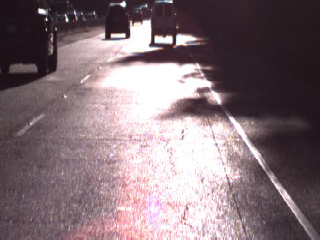

In [8]:
x = train_set.__getitem__(0)[0][0]
x = x.transpose(1, 2, 0)
Image.fromarray((x * 255).astype(np.uint8))

# Our Model


In [9]:
# Convolutional LSTM model, as in the paper 
#   Convolutional LSTM Network: A Machine Learning Approach for Precipitation Nowcasting
# https://github.com/automan000/Convolutional_LSTM_PyTorch/blob/master/convolution_lstm.py
class ConvLSTMCell(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size):
        super(ConvLSTMCell, self).__init__()

        assert hidden_channels % 2 == 0

        self.input_channels = input_channels
        self.hidden_channels = hidden_channels
        self.kernel_size = kernel_size
        self.num_features = 4

        self.padding = int((kernel_size - 1) / 2)

        self.Wxi = nn.Conv2d(self.input_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=True)
        self.Whi = nn.Conv2d(self.hidden_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=False)
        self.Wxf = nn.Conv2d(self.input_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=True)
        self.Whf = nn.Conv2d(self.hidden_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=False)
        self.Wxc = nn.Conv2d(self.input_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=True)
        self.Whc = nn.Conv2d(self.hidden_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=False)
        self.Wxo = nn.Conv2d(self.input_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=True)
        self.Who = nn.Conv2d(self.hidden_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=False)

        self.Wci = None
        self.Wcf = None
        self.Wco = None

    def forward(self, x, h, c):
        ci = torch.sigmoid(self.Wxi(x) + self.Whi(h) + c * self.Wci)
        cf = torch.sigmoid(self.Wxf(x) + self.Whf(h) + c * self.Wcf)
        cc = cf * c + ci * torch.tanh(self.Wxc(x) + self.Whc(h))
        co = torch.sigmoid(self.Wxo(x) + self.Who(h) + cc * self.Wco)
        ch = co * torch.tanh(cc)
        return ch, cc

    def init_hidden(self, batch_size, hidden, shape):
        if self.Wci is None:
            self.Wci = Variable(torch.zeros(1, hidden, shape[0], shape[1])).to(device)
            self.Wcf = Variable(torch.zeros(1, hidden, shape[0], shape[1])).to(device)
            self.Wco = Variable(torch.zeros(1, hidden, shape[0], shape[1])).to(device)
        else:
            assert shape[0] == self.Wci.size()[2], 'Input Height Mismatched!'
            assert shape[1] == self.Wci.size()[3], 'Input Width Mismatched!'
        return (Variable(torch.zeros(batch_size, hidden, shape[0], shape[1])).to(device),
                Variable(torch.zeros(batch_size, hidden, shape[0], shape[1])).to(device))


class ConvLSTM(nn.Module):
    # input_channels corresponds to the first input feature map
    # hidden state is a list of succeeding lstm layers.
    def __init__(self, input_channels, hidden_channels, kernel_size, step=1, effective_step=[1]):
        super(ConvLSTM, self).__init__()
        self.input_channels = [input_channels] + hidden_channels
        self.hidden_channels = hidden_channels
        self.kernel_size = kernel_size
        self.num_layers = len(hidden_channels)
        self.step = step
        self.effective_step = effective_step
        self._all_layers = []
        for i in range(self.num_layers):
            name = 'cell{}'.format(i)
            cell = ConvLSTMCell(self.input_channels[i], self.hidden_channels[i], self.kernel_size)
            setattr(self, name, cell)
            self._all_layers.append(cell)

    def forward(self, input):
        internal_state = []
        outputs = []
        for step in range(self.step):
            x = input
            for i in range(self.num_layers):
                # all cells are initialized in the first step
                name = 'cell{}'.format(i)
                if step == 0:
                    bsize, _, height, width = x.size()
                    (h, c) = getattr(self, name).init_hidden(batch_size=bsize, hidden=self.hidden_channels[i],
                                                             shape=(height, width))
                    internal_state.append((h, c))

                (h, c) = internal_state[i]
                x, new_c = getattr(self, name)(x, h, c)
                internal_state[i] = (x, new_c)
            outputs.append(x)

        return outputs, (x, new_c)

In [10]:
class Whip(nn.Module):
    def __init__(self, in_channels, out_channels, input_size, output_size):
        super(Whip, self).__init__()
        
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=(1, 4, 4), stride=2, padding=1)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=(3, 12, 12), stride=2, padding=1)
        self.bn2 = nn.BatchNorm3d(out_channels)
        self.relu2 = nn.ReLU()
        
        self.conv3 = nn.Conv3d(out_channels, out_channels, kernel_size=(1, 4, 4), stride=2)
        self.bn3 = nn.BatchNorm3d(out_channels)
        self.relu3 = nn.ReLU()
        
        self.avgpool = nn.AvgPool3d(1)
        
        self.convLSTM = ConvLSTM(input_channels=out_channels, hidden_channels= [512, 128, 64, 32], 
                                 kernel_size=3)
        
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, x):
        output = self.conv1(x) 
        output = self.bn1(output)
        output = self.relu1(output)
        
        output = self.conv2(output)
        output = self.bn2(output)
        output = self.relu2(output)
        
        output = self.conv3(output)
        output = self.bn3(output)
        output = self.relu3(output)
        
        output = self.avgpool(output).squeeze(2)
        
        output, hidden = self.convLSTM(output)
        output = output[0]
        
        featuresV = output.reshape(output.size(0), -1)
        output = self.fc(featuresV)
        return output

In [11]:
def combine(x, y):
    total = 0
    for v in range(len(x)):
        if x[v] and y[v]:
            total += 1
    return total

In [16]:
def train(num_epochs, model, save, optimizer, scheduler, criterion, angle_loss_weight=10.0):
    EPOCH_TRAIN_LOSSES = []
    EPOCH_VAL_LOSSES = []
    EPOCH_TRAIN_ACC = []
    EPOCH_VAL_ACC = []
    train_a_acc = []
    val_a_acc = []
    
    
    for epoch in range(num_epochs):
        start = time.time()

        running_train_loss = 0.0
        running_val_loss = 0.0
        running_train_acc = 0.0
        running_val_acc = 0.0
               
        t_correct_predictions_0_5 = 0.0
        t_correct_predictions_1 = 0.0
        t_correct_predictions_2 = 0.0
        t_correct_predictions_5 = 0.0
        t_correct_predictions_g_5 = 0.0
        
        v_correct_predictions_0_5 = 0.0
        v_correct_predictions_1 = 0.0
        v_correct_predictions_2 = 0.0
        v_correct_predictions_5 = 0.0
        v_correct_predictions_g_5 = 0.0

        model.train()
        for i, (x, label) in enumerate(train_dataloader):
            x, label = x.to(device), label.to(device)
            optimizer.zero_grad()
            y = model(x.float()).double().squeeze(1)
            
            loss = angle_loss_weight * criterion(y[:,0], label[:,0]) + \
                                    criterion(y[:,1], label[:,1]) + \
                                    criterion(y[:,2], label[:,2])
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
            predicted_angles = y[0]
            label_angles = label[0]
            running_train_acc += torch.mean(torch.abs(predicted_angles - label_angles)).item()
            t_correct_predictions_0_5 += torch.sum(torch.abs(predicted_angles - label_angles) <= 0.5).item()
            t_correct_predictions_1 += combine(torch.abs(predicted_angles - label_angles) > 0.5,  torch.abs(predicted_angles - label_angles) <= 1)
            t_correct_predictions_2 += combine(torch.abs(predicted_angles - label_angles) > 1,  torch.abs(predicted_angles - label_angles) <= 2)
            t_correct_predictions_5 += combine(torch.abs(predicted_angles - label_angles) > 2,  torch.abs(predicted_angles - label_angles) <= 5)
            v_correct_predictions_g_5 += torch.sum(torch.abs(predicted_angles - label_angles) > 5).item()
            
            del x
            del label
                    
        train_a_a = [t_correct_predictions_0_5, t_correct_predictions_1, t_correct_predictions_2, t_correct_predictions_5, t_correct_predictions_g_5]
        train_a_acc.append(train_a_a)

        model.eval()
        with torch.no_grad():
            for i, (x, label) in enumerate(val_dataloader):
                x, label = x.to(device), label.to(device)
                y = model(x.float()).double().squeeze(1)
                
                loss = angle_loss_weight * criterion(y[:,0], label[:,0]) + \
                            criterion(y[:,1], label[:,1]) + \
                            criterion(y[:,2], label[:,2])

                running_val_loss += loss.item()
                predicted_angles = y[0]
                label_angles = label[0]
                running_val_acc += torch.mean(torch.abs(predicted_angles - label_angles)).item()
                v_correct_predictions_0_5 += torch.sum(torch.abs(predicted_angles - label_angles) <= 0.5).item()
                v_correct_predictions_1 += combine(torch.abs(predicted_angles - label_angles) > 0.5,  torch.abs(predicted_angles - label_angles) <= 1)
                v_correct_predictions_2 += combine(torch.abs(predicted_angles - label_angles) > 1,  torch.abs(predicted_angles - label_angles) <= 2)
                v_correct_predictions_5 += combine(torch.abs(predicted_angles - label_angles) > 2,  torch.abs(predicted_angles - label_angles) <= 5)
                v_correct_predictions_g_5 += torch.sum(torch.abs(predicted_angles - label_angles) > 5).item()
                
                del x
                del label
                
            val_a_a = [v_correct_predictions_0_5, v_correct_predictions_1, v_correct_predictions_2, v_correct_predictions_5, v_correct_predictions_g_5]
            val_a_acc.append(val_a_a)
                
        train_acc = running_train_acc / len(train_dataloader)
        val_acc = running_val_acc / len(val_dataloader)
        tloss = running_train_loss / len(train_dataloader)
        vloss = running_val_loss/ len(val_dataloader)

        print("EPOCH", epoch, "\t\tTook", int(time.time() - start), "s")
        print("Train Acc:", round(train_acc, 4), "\tVal Acc:", round(val_acc, 4))
        print("Avg Train Loss:", round(tloss, 4), "\tAvg Val Loss:", round(vloss, 4))
        print("===================================================================")

        scheduler.step(vloss)

        EPOCH_TRAIN_LOSSES.append(tloss)
        EPOCH_VAL_LOSSES.append(vloss)
        EPOCH_TRAIN_ACC.append(train_acc)
        EPOCH_VAL_ACC.append(val_acc)

        if save:
            torch.save(model.state_dict(), './model_' + str(epoch + 1) + '_' + str(val_acc) + '.pt')
            
    return EPOCH_TRAIN_LOSSES, EPOCH_VAL_LOSSES, EPOCH_TRAIN_ACC, EPOCH_VAL_ACC, val_a_acc, train_a_acc

In [17]:
context_size = 15
out_channels = 13
# input_size = 140448     # use this if using original image size
input_size = 31968

# we will be predicting angle, torque, and speed
output_size = 3
model = Whip(context_size, out_channels, input_size, output_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)
criterion = nn.MSELoss()

print(model)

Whip(
  (conv1): Conv3d(15, 13, kernel_size=(1, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
  (bn1): BatchNorm3d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv3d(13, 13, kernel_size=(3, 12, 12), stride=(2, 2, 2), padding=(1, 1, 1))
  (bn2): BatchNorm3d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (conv3): Conv3d(13, 13, kernel_size=(1, 4, 4), stride=(2, 2, 2))
  (bn3): BatchNorm3d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (avgpool): AvgPool3d(kernel_size=1, stride=1, padding=0)
  (convLSTM): ConvLSTM(
    (cell0): ConvLSTMCell(
      (Wxi): Conv2d(13, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (Whi): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (Wxf): Conv2d(13, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (Whf): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
n_epochs = 15
results = train(n_epochs, model, False, optimizer, scheduler, criterion)
[EPOCH_TRAIN_LOSSES, EPOCH_VAL_LOSSES, EPOCH_TRAIN_ACC, EPOCH_VAL_ACC, val_a_acc, train_a_acc] = results

EPOCH 0 		Took 1029 s
Train Acc: 4.4385 	Val Acc: 2.0135
Avg Train Loss: 1132.1774 	Avg Val Loss: 248.0401


# Plotting Results

In [ ]:
import matplotlib.pyplot as plt

ep = np.arange(n_epochs)

rangeVi = 0
rangeVf = n_epochs
plt.plot(ep[rangeVi:rangeVf], EPOCH_TRAIN_LOSSES[rangeVi:rangeVf], label="Train")
plt.plot(ep[rangeVi:rangeVf], EPOCH_VAL_LOSSES[rangeVi:rangeVf], label="Validation")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title("Epochs vs Loss")
plt.legend()
plt.savefig('LossGraph.png')

plt.show()

plt.plot(ep[rangeVi:rangeVf], EPOCH_TRAIN_ACC[rangeVi:rangeVf], label="Train")
plt.plot(ep[rangeVi:rangeVf], EPOCH_VAL_ACC[rangeVi:rangeVf], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Average Degree Distance")
plt.title("Epochs vs Average Degree Distance")
plt.legend()
plt.savefig('AccuracyGraph.png')
plt.show()


In [ ]:

objects = ('[0, 0.5]', '(0.5, 1]', '(1, 2]', '(2, 5]', '(5, Inf.)')
performanceV = val_a_acc[-1]
performanceT = train_a_acc[0]

x = np.arange(len(objects))
width = 0.2 # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, performanceV, width, label="Validation")
rects1 = ax.bar(x + width/2, performanceT, width, label="Training")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Training Points')
ax.set_title('Accuracy for Last Epoch')
ax.set_xticks(x)
plt.ylim(0, 1000)
labels = []
totalV = sum(performanceV)
totalT = sum(performanceT)

for x in range(len(objects)):
    labels.append(objects[x] + "\n" + str(int((performanceV[x]/totalV)*100)) + "%," + str(int((performanceT[x]/totalT)*100)) + "%")
ax.set_xticklabels(labels)
ax.legend()
plt.show()
plt.savefig('Last_Epoch.png', dpi=300)

objects = ('[0, 0.5]', '(0.5, 1]', '(1, 2]', '(2, 5]', '(5, Inf.)')
performanceV = val_a_acc[0]
performanceT = train_a_acc[-1]

x = np.arange(len(objects))
# print(v_all_a)
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, performanceV, width, label="Validation")
rects1 = ax.bar(x + width/2, performanceT, width, label="Training")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Training Points')
ax.set_title('Accuracy for First Epoch')
ax.set_xticks(x)
plt.ylim(0, 1000)
labels = []
totalV = sum(performanceV)
totalT = sum(performanceT)

for x in range(len(objects)):
    labels.append(objects[x] + "\n" + str(int((performanceV[x]/totalV)*100)) + "%," + str(int((performanceT[x]/totalT)*100)) + "%")
ax.set_xticklabels(labels)
ax.legend()
plt.show()
plt.savefig('Zero_Epoch.png', dpi=300)
